In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.set_default_device(torch.device("cpu" if torch.cuda.is_available() else "cpu"))

In [10]:
import torch
from torch import nn, device


class Encoder(nn.Module):
    def __init__(self, hidden_channels: int) -> None:
        super().__init__()

        self.lrelu = nn.LeakyReLU()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2),
            self.lrelu
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            self.lrelu
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=hidden_channels, kernel_size=1, stride=1, padding=0),
            self.lrelu
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        # print(f"enc block 1: {x.size()}")
        x = self.block2(x)
        # print(f"enc block 2: {x.size()}", end="\n\n")
        x = self.block3(x)
        # print(f"latent space: {x.size()}", end="\n\n")
        return x

In [11]:
import torch
from torch import nn


class Decoder(nn.Module):
    def __init__(self, hidden_channels: int) -> None:
        super().__init__()

        self.lrelu = nn.LeakyReLU()

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=64, kernel_size=1, stride=1, padding=0),
            self.lrelu
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0),
            self.lrelu
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        # print(f"dec block 1: {x.size()}")
        x = self.block2(x)
        # print(f"dec block 2: {x.size()}")
        x = self.block3(x)
        # print(f"post dec: {x.size()}")
        return x

In [12]:
import torch
from torch import nn


class VAE(nn.Module):
    def __init__(self, hidden_channels) -> None:
        super().__init__()
        self.encoder = Encoder(hidden_channels)
        self.decoder = Decoder(hidden_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = VAE(hidden_channels=4).to("cuda")

In [13]:
foo = torch.randn(28, 28).to("cuda")
foo = foo.unsqueeze(0)
print(f"pre enc:{foo.size()}")
foo = model(foo)

pre enc:torch.Size([1, 28, 28])


In [14]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='mnist_data',
                            train=True,
                            download=True,
                            transform=ToTensor(),
                            target_transform=None)

test_data = datasets.MNIST(root='mnist_data',
                           train=False,
                           download=True,
                           transform=ToTensor(),
                           target_transform=None)

train_data.data = train_data.data.unsqueeze(1).to("cuda").float() / 255.0
train_data.targets = train_data.targets.to("cuda")

test_data.data = test_data.data.unsqueeze(1).to("cuda").float() / 255.0
test_data.targets = test_data.targets.to("cuda")

from torch.utils.data import DataLoader


class GPUDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset.data
        self.targets = dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]  # Normalize here if needed


T | E 1/10 - 10.000% | Loss: 0.02128
V | Loss: 0.01848
T | E 2/10 - 20.000% | Loss: 0.01686
V | Loss: 0.01555
T | E 3/10 - 30.000% | Loss: 0.01569
V | Loss: 0.01483
T | E 4/10 - 40.000% | Loss: 0.01503
V | Loss: 0.01427
T | E 5/10 - 50.000% | Loss: 0.01463
V | Loss: 0.01436
T | E 6/10 - 60.000% | Loss: 0.01475
V | Loss: 0.01440
T | E 7/10 - 70.000% | Loss: 0.01433
V | Loss: 0.01464
T | E 8/10 - 80.000% | Loss: 0.01415
V | Loss: 0.01321
T | E 9/10 - 90.000% | Loss: 0.02130
V | Loss: 0.01900
T | E 10/10 - 100.000% | Loss: 0.01687
V | Loss: 0.01561


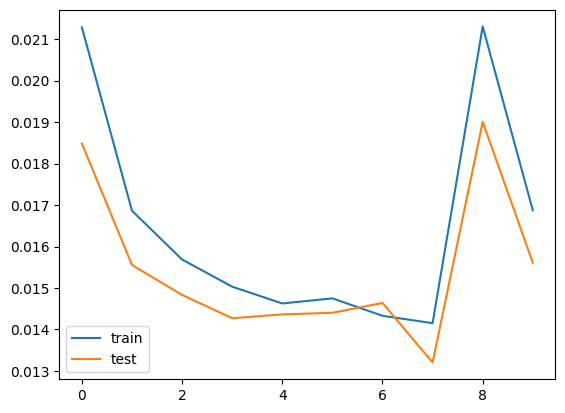

In [15]:
EPOCHS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 32
UPDATE_EVERY_NUM_BATCHES = 1

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataset, test_dataset = GPUDataset(train_data), GPUDataset(test_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_loss_history, test_loss_history = [], []
train_loss_batches, test_loss_batches = [], []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    current_batch = 0
    train_loss, test_loss = 0, 0

    for batch_index, (X, Y) in enumerate(train_dataloader):
        output = model(X)
        loss = loss_fn(output, X)
        loss.backward()
        train_loss_batches.append(loss.item())
        train_loss += loss.item() * len(X)
        if current_batch % UPDATE_EVERY_NUM_BATCHES == 0:
            optimizer.step()
            optimizer.zero_grad()
    train_loss /= len(train_data)
    train_loss_history.append(train_loss)
    print(f"T | E {epoch + 1:,}/{EPOCHS:,} - {((epoch + 1) / EPOCHS) * 100:.3f}% | Loss: {train_loss:.5f}")

    model.eval()
    with torch.inference_mode():
        for batch_index, (X, Y) in enumerate(test_dataloader):
            output = model(X)
            loss = loss_fn(output, X)
            test_loss_batches.append(loss.item())
            test_loss += loss.item() * len(X)
    test_loss /= len(test_data)
    test_loss_history.append(test_loss)
    print(f"V | Loss: {test_loss:.5f}")

import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(["train", "test"])
plt.show()

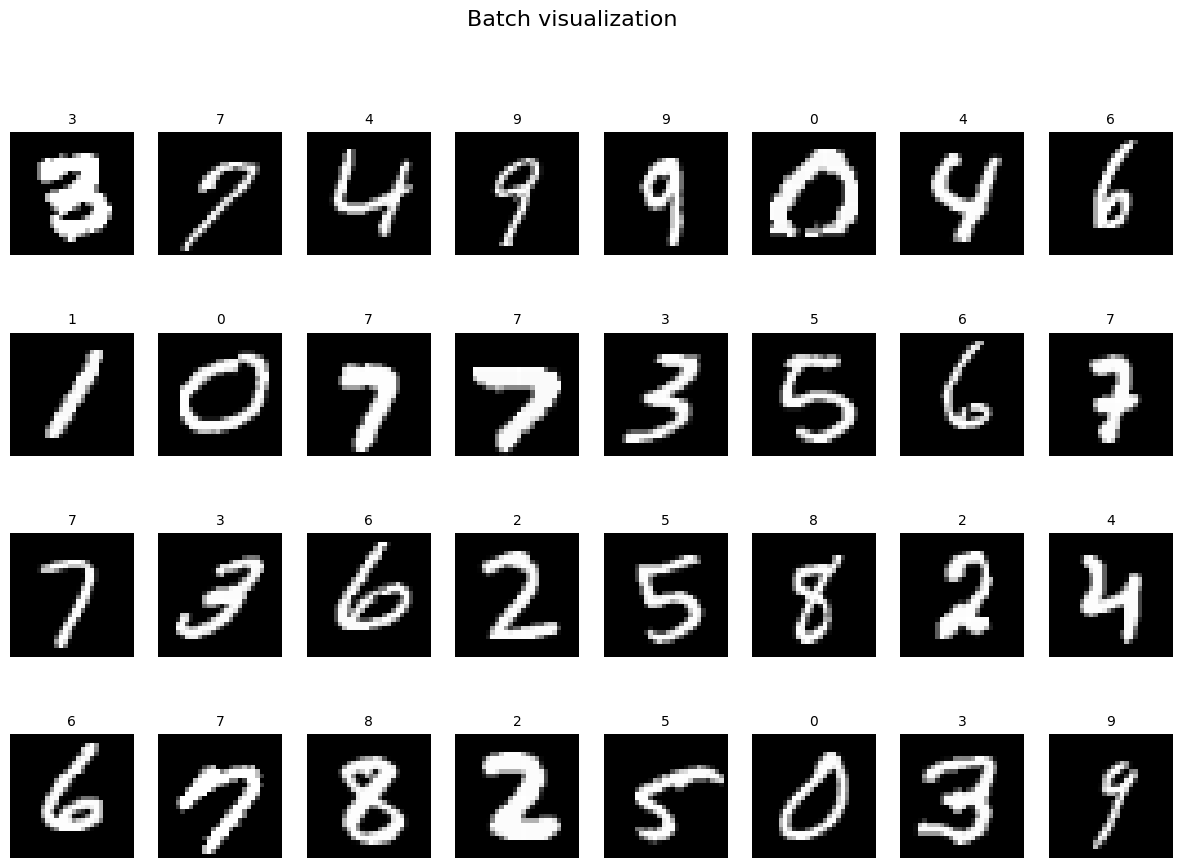

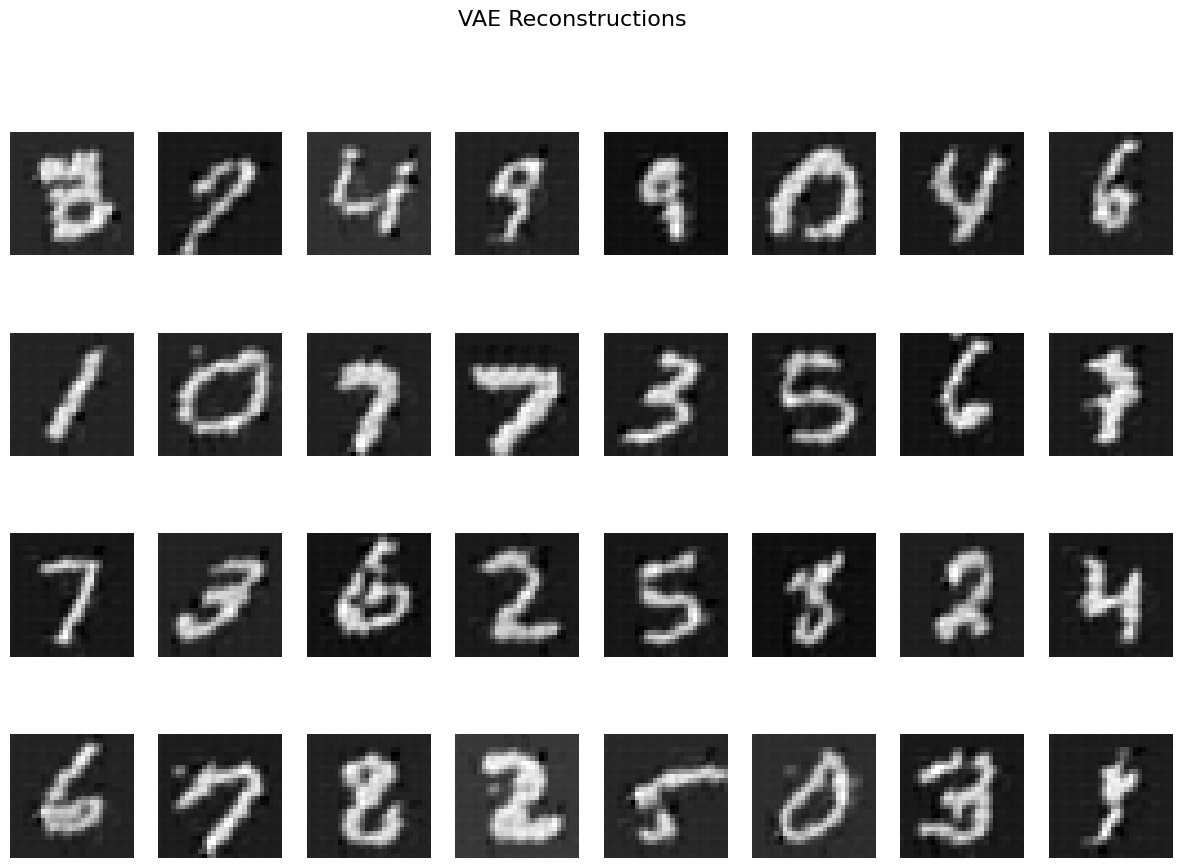

In [16]:
import numpy as np

x_batch, y_batch = next(iter(train_dataloader))
reconstruction = model(x_batch)
x_batch = x_batch.cpu().numpy()

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))
fig.suptitle("Batch visualization", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i, 0], cmap="gray")
    ax.set_title(f"{y_batch[i].item()}", fontsize=10)
    ax.axis("off")  # Hide axes

plt.show()

reconstruction = reconstruction.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))
fig.suptitle("VAE Reconstructions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(reconstruction[i, 0], cmap="gray")
    ax.axis("off")  # Hide axes

plt.show()